In [1]:
!pip install ipywidgets
!pip install accelerate
!pip install pfrl@git+https://github.com/voidful/pfrl.git
!pip install textrl
#instal nltk
!pip install nltk
!pip install sentencepiece
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 108.2 MB 3.1 MB/s eta 0:00:01
     |██████████████▉                 | 287.6 MB 2.9 MB/s eta 0:01:55     |██████████                      | 192.1 MB 3.1 MB/s eta 0:02:16

In [2]:
from DualRLStyleTransfer.load_and_prepare_data import load_dataset_yelp_reviews
import matplotlib.pyplot as plt
import numpy as np

train_data, test_data, dev_data, test_data_and_references = load_dataset_yelp_reviews()

train_negative_to_positive_dataX = []
train_negative_to_positive_dataY = []
train_positive_to_negative_dataX = []
train_positive_to_negative_dataY = []

for i in range(0,4):
    print(test_data_and_references[i])


for i in range(0,len(test_data_and_references)):
    input = test_data_and_references[i]['input']
    label = test_data_and_references[i]['label']
    ref = test_data_and_references[i]['ref']
    for r in ref:
        if label == 'NEGATIVE':
            train_negative_to_positive_dataX.append(input)
            train_negative_to_positive_dataY.append(r)
        else:
            train_positive_to_negative_dataX.append(input)
            train_positive_to_negative_dataY.append(r)

#shuffle data
from sklearn.utils import shuffle
train_negative_to_positive_dataX, train_negative_to_positive_dataY = shuffle(train_negative_to_positive_dataX, train_negative_to_positive_dataY)
train_positive_to_negative_dataX, train_positive_to_negative_dataY = shuffle(train_positive_to_negative_dataX, train_positive_to_negative_dataY)
for i in range(0,5):
    print(train_negative_to_positive_dataX[i],"-->",train_negative_to_positive_dataY[i])


./DualRLStyleTransfer/yelp_data/test.0
./DualRLStyleTransfer/yelp_data/test.1
./DualRLStyleTransfer/yelp_data/dev.0
./DualRLStyleTransfer/yelp_data/dev.1
./DualRLStyleTransfer/yelp_data/train.0
./DualRLStyleTransfer/yelp_data/train.1
./DualRLStyleTransfer/yelp_refrence/reference0.0
./DualRLStyleTransfer/yelp_refrence/reference0.1
./DualRLStyleTransfer/yelp_refrence/reference1.0
./DualRLStyleTransfer/yelp_refrence/reference1.1
./DualRLStyleTransfer/yelp_refrence/reference2.0
./DualRLStyleTransfer/yelp_refrence/reference2.1
./DualRLStyleTransfer/yelp_refrence/reference3.0
./DualRLStyleTransfer/yelp_refrence/reference3.1
{'input': "ever since joes has changed hands it's just gotten worse and worse.", 'label': 'NEGATIVE', 'ref': ["ever since joes has changed hands it's gotten better and better.", 'ever since joes has changed hands it`s gotten better and better.', 'since joe changed hands, it has become a better place.', 'ever since joes has changed hands it is getting better']}
{'input': '

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from DualRLStyleTransfer.bleu_evaluate import *

batch_size = 1
epochs = 10



tokenizer = T5Tokenizer.from_pretrained("t5-small")
model_pos_to_neg = T5ForConditionalGeneration.from_pretrained("t5-small")
model_pos_to_neg.eval()
model_pos_to_neg.cuda()

model_neg_to_pos = T5ForConditionalGeneration.from_pretrained("t5-small")
model_neg_to_pos.eval()
model_neg_to_pos.cuda()

#tokenize data and create tensors for input and output
encoding_pos_to_neg = tokenizer(train_positive_to_negative_dataX,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
target_encoding_pos_to_neg = tokenizer(train_positive_to_negative_dataY,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
encoding_neg_to_pos = tokenizer(train_negative_to_positive_dataX,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
target_encoding_neg_to_pos = tokenizer(train_negative_to_positive_dataY,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
print("tokenized data shape")
print(encoding_pos_to_neg['input_ids'].shape)
print(target_encoding_pos_to_neg['input_ids'].shape)
print(encoding_neg_to_pos['input_ids'].shape)
print(target_encoding_neg_to_pos['input_ids'].shape)

RuntimeError: Failed to import transformers.models.t5.modeling_t5 because of the following error (look up to see its traceback):
/usr/local/lib/python3.8/dist-packages/transformer_engine_extensions.cpython-38-x86_64-linux-gnu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

In [38]:
#train positive to negative model
optimizer = torch.optim.Adam(model_pos_to_neg.parameters(), lr=5e-5)

model_pos_to_neg_traning_results = []
for epoch in range(0,epochs):
    print("epoch", epoch)
    for i in range(0,len(train_positive_to_negative_dataX),batch_size):
        input_ids, attention_mask = encoding_pos_to_neg.input_ids[i:i+batch_size], encoding_pos_to_neg.attention_mask[i:i+batch_size]
        labels = target_encoding_pos_to_neg.input_ids[i:i+batch_size]

        loss = model_pos_to_neg(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i % 10 == 0:
            #input_string = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            #target_string = tokenizer.decode(labels[0], skip_special_tokens=True)
            #output_string = tokenizer.decode(model_pos_to_neg.generate(input_ids=input_ids[0], attention_mask=attention_mask[0], max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
            #print("loss", loss.loss.item(), "input", input_string, "-->", target_string)
            model_pos_to_neg_traning_results.append(loss.loss.item())


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


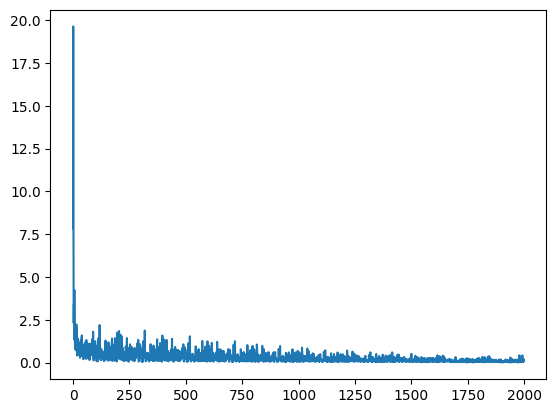

the food is terrible
the food is not good and the service is bad
ugly views and lots of variety of length and layout of holes
restaurant personnel are unpleasant
i hate everything about this place
hostess
they do so many things wrong. especially taking care of the customers.
the homemade tomato soup with asiago cheese was bad as well


In [39]:
#plot training results
plt.plot(model_pos_to_neg_traning_results)
plt.show()
#demostrate model positive to negative performance on test data
test_data_pos_to_neg = [
    "I love this place. The food is amazing.",
    "I love this place. The food is amazing. The service is great.",
    "beautiful views and lots of variety of length and layout of holes",
    "restaurant personnel are pleasant",
    "i love everything about this place",
    "is a delightful hostess and makes you feel welcome",
    "they do so many things right. especially taking care of the customers",
    "the homemade tomato soup with asiago cheese was delicious as well"
]
encoding_pos_to_neg = tokenizer(test_data_pos_to_neg,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
outputs = model_pos_to_neg.generate(input_ids=encoding_pos_to_neg.input_ids, attention_mask=encoding_pos_to_neg.attention_mask, max_length=150, num_beams=5, early_stopping=True)
for output in outputs:
    print(tokenizer.decode(output, skip_special_tokens=True))

In [40]:
#train negative to positive model
optimizer = torch.optim.Adam(model_neg_to_pos.parameters(), lr=5e-5)
model_neg_to_pos_traning_results = []
for epoch in range(0,epochs):
    print("epoch", epoch)
    for i in range(0,len(train_negative_to_positive_dataX),batch_size):
        input_ids, attention_mask = encoding_neg_to_pos.input_ids[i:i+batch_size], encoding_neg_to_pos.attention_mask[i:i+batch_size]
        labels = target_encoding_neg_to_pos.input_ids[i:i+batch_size]

        loss = model_neg_to_pos(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i % 10 == 0:
            
            #input_string = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            #target_string = tokenizer.decode(labels[0], skip_special_tokens=True)
            #output_string = tokenizer.decode(model_neg_to_pos.generate(input_ids=input_ids[0], attention_mask=attention_mask[0], max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
            #print("loss", loss.loss.item(), "input", input_string, "-->", target_string)
            model_neg_to_pos_traning_results.append(loss.loss.item())
    

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


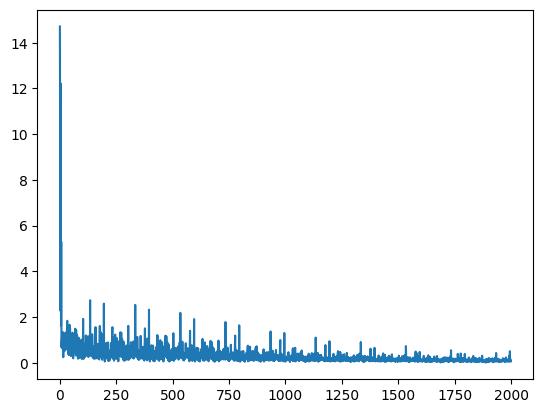

the food is amazing.
there is a good amount of grass on the range
bottom line, this place sucks in
i buy this place for myself
very satisfied in the customer service


In [41]:
#plot training results
plt.plot(model_neg_to_pos_traning_results)
plt.show()
#demostrate model negative to positive performance on test data
test_data_neg_to_pos = [
    "I hate this place. The food is terrible.",
    "there is no grass on the range",
    "bottom line , this place sucks",
    "someone should buy this place and turn it into what it should be",
    "very disappointed in the customer service",
]
encoding_neg_to_pos = tokenizer(test_data_neg_to_pos,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
outputs = model_neg_to_pos.generate(input_ids=encoding_neg_to_pos.input_ids, attention_mask=encoding_neg_to_pos.attention_mask, max_length=150, num_beams=5, early_stopping=True)
for output in outputs:
    print(tokenizer.decode(output, skip_special_tokens=True))
    

In [42]:
#save models
model_pos_to_neg.save_pretrained("DualRLStyleTransfer/models/pos_to_neg")
model_neg_to_pos.save_pretrained("DualRLStyleTransfer/models/neg_to_pos")

In [1]:
#load models
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
import torch
from DualRLStyleTransfer.load_and_prepare_data import load_dataset_yelp_reviews
train_data, test_data, dev_data, test_data_and_references = load_dataset_yelp_reviews()

model_pos_to_neg = T5ForConditionalGeneration.from_pretrained("DualRLStyleTransfer/models/pos_to_neg").to('cuda')
model_neg_to_pos = T5ForConditionalGeneration.from_pretrained("DualRLStyleTransfer/models/neg_to_pos").to('cuda')
tokenizer = T5Tokenizer.from_pretrained("t5-small")
sentiment = pipeline('sentiment-analysis', model="DualRLStyleTransfer/models/sentiment_roberta-large-english", tokenizer=tokenizer)

RuntimeError: Failed to import transformers.models.t5.modeling_t5 because of the following error (look up to see its traceback):
/usr/local/lib/python3.8/dist-packages/transformer_engine_extensions.cpython-38-x86_64-linux-gnu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

In [44]:
#quck sentiment analysis test
print(sentiment("I love this place. The food is amazing."))
print(sentiment("I hate this place. The food is terrible."))
print(sentiment("bottom line , this place sucks."))
print(sentiment("very disappointed in the customer service."))

[{'label': 'POSITIVE', 'score': 0.9897312521934509}]
[{'label': 'NEGATIVE', 'score': 0.9919760823249817}]
[{'label': 'POSITIVE', 'score': 0.9872738122940063}]
[{'label': 'POSITIVE', 'score': 0.9979404807090759}]


In [48]:
input = "you get so much for the price and the food is fresh and delicious"
encoding = tokenizer(input,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
outputs = model_pos_to_neg.generate(input_ids=encoding.input_ids, attention_mask=encoding.attention_mask, max_length=150, num_beams=5, early_stopping=True)
for output in outputs:
    print(tokenizer.decode(output, skip_special_tokens=True))

you don't get very much for the price and the food is bad and bad


# Evaluating the two models fine-tuned on the parallel data
Note this is not a perfect evaluation as the models were trained on the same data as the test set. However, it is a good indicator of how well the models are doing. The available parallel data is very small so we use all the data when fine-tune the model trained on much larger data set, hoping that the model will learn to generalize well, by taking advantage of the pre-trained weights.
Score is assigned by combining multiple metrics:
- BLEU score of the model's output compared to the reference output. (does the model preserve the content of the input text)
- Accuracy of the sentiment transfer (does the model change the sentiment of the input text correctly).

In [46]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

pos_data = []
pos_data_refs = []
neg_data = []
neg_data_refs = []
for i in range(0,len(test_data_and_references)):
    input = test_data_and_references[i]['input']
    label = test_data_and_references[i]['label']
    ref = test_data_and_references[i]['ref']
    if label == 'NEGATIVE':
        neg_data.append(input)
        neg_data_refs.append(ref)
    else:
        pos_data.append(input)
        pos_data_refs.append(ref)

encoding_pos_data = tokenizer(pos_data,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
encoding_neg_data = tokenizer(neg_data,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')

#outputs_pos_to_neg = model_pos_to_neg.generate(input_ids=encoding_pos_data.input_ids, attention_mask=encoding_pos_data.attention_mask, max_length=150, num_beams=5, early_stopping=True)
#output_strings = tokenizer.decode(outputs_pos_to_neg, skip_special_tokens=True)
#calculate bleu scor
avg_bleu_score = 0
for i in range(0,len(encoding_pos_data.input_ids)):
    input_ids, attention_mask = encoding_pos_data.input_ids[i:i+1], encoding_pos_data.attention_mask[i:i+1]
    #output_string = output_strings[i]
    output_string = tokenizer.decode(model_pos_to_neg.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
    refrences = []
    for ref in pos_data_refs[i]:
        refrences.append(ref.split())
    bleu_score = sentence_bleu(refrences,output_string.split())
    avg_bleu_score += bleu_score
    print(pos_data[i],"-->" ,output_string, "score", bleu_score)
avg_bleu_score = avg_bleu_score / len(encoding_pos_data.input_ids)
print("avg bleu score for pos to negative model", avg_bleu_score)

it's small yet they make you feel right at home. --> it's small and make you feel as small office cabin score 1.0
i will be going back and enjoying this great place! --> i will not be going back to this terrible place! score 1.0
the drinks were affordable and a good pour. --> the drinks were expensive and a less pour score 1.0
my husband got a ruben sandwich, he loved it. --> my husband got a ruben sandwich, he hated it. score 1.0
i signed up for their email and got a coupon. --> i signed up for their email and got spam. score 1.0
i'd definitely recommend giving them a try. --> i'd definitely recommend not giving them a try. score 1.0
i highly recommend e & m painting. --> i will never recommend e & m painting score 1.0
otherwise a great experience and we will go again. --> otherwise a bad experience and we will not go again. score 1.0
good drinks, and good company. --> bad drinks and poor company score 1.0
oh i got my band geek back on now! --> not happy oh i did not get my band geek 

In [47]:
#calculate bleu score for negative to positive model
avg_bleu_score = 0
for i in range(0,len(encoding_neg_data.input_ids)):
    input_ids, attention_mask = encoding_neg_data.input_ids[i:i+1], encoding_neg_data.attention_mask[i:i+1]
    output_string = tokenizer.decode(model_neg_to_pos.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
    refrences = []
    for ref in neg_data_refs[i]:
        refrences.append(ref.split())
    bleu_score = sentence_bleu(refrences,output_string.split())
    avg_bleu_score += bleu_score
    print(neg_data[i],"-->" ,output_string, "score", bleu_score)
avg_bleu_score = avg_bleu_score / len(encoding_neg_data.input_ids)
print("avg bleu score for neg to positive model", avg_bleu_score)

ever since joes has changed hands it's just gotten worse and worse. --> ever since joes has changed hands its gotten better and better. score 0.7016879391277372
there is definitely not enough room in that part of the venue. --> there is enough room in that oart of the venue. score 0.8408964152537145
so basically tasted watered down. --> so basically not tasted watered down. score 1.0
she said she'd be back and disappeared for a few minutes. --> she said she'd be back and will not disappeared score 1.0
i ca n't believe how inconsiderate this pharmacy is. --> the pharmacy was so considerate of me score 1.0
just left and took it off the bill. --> just left and i will come back. score 1.0
it is n't terrible, but it is n't very good either. --> it isn't perfect, but it is very good. score 0.6240195441936914
definitely disappointed that i could not use my birthday gift! --> i was very happy to see my birthday present. score 1.0
new owner, i heard-but i do n't know the details. --> new owner,

In [ ]:
positive_reviews = []
negative_reviews = []
for i in range(0,len(train_data)):
    if train_data[i]['label'] == 'POSITIVE':
        positive_reviews.append(train_data[i]['input'])
    else:
        negative_reviews.append(train_data[i]['input'])
encoding_positive_reviews = tokenizer(positive_reviews,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')
encoding_negative_reviews = tokenizer(negative_reviews,padding="longest",max_length=150,truncation=True,return_tensors="pt",).to('cuda')

In [50]:
for i in range(0,10):
    input_ids, attention_mask = encoding_positive_reviews.input_ids[i:i+1], encoding_positive_reviews.attention_mask[i:i+1]
    output_string = tokenizer.decode(model_pos_to_neg.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
    print(positive_reviews[i],"-->" ,output_string)

    input_ids, attention_mask = encoding_negative_reviews.input_ids[i:i+1], encoding_negative_reviews.attention_mask[i:i+1]
    output_string = tokenizer.decode(model_neg_to_pos.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150, num_beams=5, early_stopping=True)[0], skip_special_tokens=True)
    print(negative_reviews[i],"-->" ,output_string)

excellent food. --> bad food.
i was sadly mistaken. --> i was very careful
superb customer service. --> poor customer service
so on to the hoagies, the italian is general run of the mill. --> the italien is general run of the mill.
they also have daily specials and ice cream which is really good. --> they also have daily specials and ice cream which is really bad
minimal meat and a ton of shredded lettuce. --> minimal meat and a ton of shredded lettuce
it's a good toasted hoagie. --> it's a bad toasted hoagie
nothing really special & not worthy of the $_num_ price tag. --> everything really special & worthy of the $_num_ price tag.
the staff is friendly. --> the staff is unfriendly.
second, the steak hoagie, it is atrocious. --> second, the steak hoagie, it is amazing
good bar food. --> bad bar food.
i had to pay $_num_ to add cheese to the hoagie. --> i had to pay $_num_ to add cheese to the hoagie.
good service. --> bad service.
she told me there was a charge for the dressing on the 